In [1]:
# EN CONSOLA

# sudo apt update
# sudo apt install -y make build-essential libssl-dev zlib1g-dev \
#  libbz2-dev libreadline-dev libsqlite3-dev curl \
#  llvm libncursesw5-dev xz-utils tk-dev libxml2-dev libxmlsec1-dev libffi-dev liblzma-dev
# curl https://pyenv.run | bash
# nano onstart.sh

# Agregar:
# export PYENV_ROOT="$HOME/.pyenv"
# export PATH="$PYENV_ROOT/bin:$PATH"
# eval "$(pyenv init --path)"
# eval "$(pyenv init -)"
# eval "$(pyenv virtualenv-init -)"
# source onstart.sh

# pyenv install 3.11.8
# pyenv virtualenv 3.11.8 tfm
# pyenv activate tfm

# python -m pip install --upgrade pip
# pip uninstall -y numpy
# pip install numpy==1.26.4 --force-reinstall
# pip install boto3
# pip install tqdm
# pip install pandas
# pip install wandb
# export WANDB_API_KEY=<your_api_key>
# wandb login
# python -m pip install -U matplotlib
# pip install torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cu121 --resume-retries=5
# pip install ipykernel
# python -m ipykernel install --user --name tfm --display-name "TFM (Python 3.11)"

# git clone https://github.com/theviderlab/landmark-retrieval-pipeline.git .

# Para descargar dataset Open Images
# mkdir assets
# cd assets
# mkdir weigths
# mkdir database
# mkdir open-images
# cd open-images
# wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
# python downloader.py image_ids_touristic_val.csv --download_folder=validation --num_processes=5
# python downloader.py image_ids_touristic_test.csv --download_folder=test --num_processes=5
# python downloader.py image_ids_touristic.csv --download_folder=train --num_processes=5


In [2]:
import os, sys
from PIL import Image
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import wandb
import math
import numpy as np

import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision.models.detection import FasterRCNN
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes, make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Dataset

# Paths
base_path = "/workspace/"
dataset_path = os.path.join(base_path, "assets/database/open-images")
train_dataset_path = os.path.join(dataset_path, "train")
val_dataset_path = os.path.join(dataset_path, "validation")

train_csv_path = os.path.join(dataset_path, "annotations_touristic_train.csv")
val_csv_path = os.path.join(dataset_path, "annotations_touristic_val.csv")

# Cargar de anotaciones
df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)

In [5]:
def verify_images(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    if "image_id" not in df.columns:
        print(f"❌ El CSV {csv_path} no tiene columna 'file_name'")
        return
    missing = []
    for fname in df["image_id"]:
        img_path = os.path.join(images_dir, fname + ".jpg")
        if not os.path.exists(img_path):
            missing.append(img_path)
    total = len(df)
    print(f"📂 {total} entradas en {csv_path}")
    if not missing:
        print(f"✅ Todas las imágenes existen en {images_dir}\n")
    else:
        print(f"⚠️  {len(missing)} imágenes faltantes en {images_dir}:")
        for p in missing[:10]:
            print("   ", p)
        if len(missing) > 10:
            print(f"   ... y otros {len(missing) - 10} archivos faltantes\n")

# Ejecutar verificación
print("Verificando conjunto de entrenamiento:")
verify_images(train_csv_path, train_dataset_path)

print("Verificando conjunto de validación:")
verify_images(val_csv_path, val_dataset_path)

Verificando conjunto de entrenamiento:
📂 371892 entradas en /workspace/assets/database/open-images/annotations_touristic_train.csv
✅ Todas las imágenes existen en /workspace/assets/database/open-images/train

Verificando conjunto de validación:
📂 3359 entradas en /workspace/assets/database/open-images/annotations_touristic_val.csv
✅ Todas las imágenes existen en /workspace/assets/database/open-images/validation



In [6]:
# Clases
thing_classes = thing_classes = df_train['label'].unique()
num_classes = 1 + len(thing_classes)  # +1 para background
thing_classes

array(['Building', 'Skyscraper', 'Sculpture', 'Tower', 'Fountain',
       'Castle', 'Lighthouse'], dtype=object)

In [7]:
# Umbrales mínimos (relativos al tamaño de la imagen)
MIN_WIDTH_REL  = 0.01
MIN_HEIGHT_REL = 0.01

def filter_bbox_errors(df: pd.DataFrame,
                       min_w_rel: float = MIN_WIDTH_REL,
                       min_h_rel: float = MIN_HEIGHT_REL) -> pd.DataFrame:
    """
    Devuelve un DataFrame sin las anotaciones con:
      - ancho/alto no positivos (xmax ≤ xmin ó ymax ≤ ymin)
      - coordenadas fuera de [0,1]
      - ancho o alto menor que el umbral relativo mínimo
    """
    # a) Área no positiva
    cond_nonpos = (df['xmax'] <= df['xmin']) | (df['ymax'] <= df['ymin'])
    # b) Coordenadas fuera de rango [0,1]
    coords = df[['xmin','ymin','xmax','ymax']]
    cond_oob = (coords < 0).any(axis=1) | (coords > 1).any(axis=1)
    # c) Dimensiones demasiado pequeñas
    widths_rel  = df['xmax'] - df['xmin']
    heights_rel = df['ymax'] - df['ymin']
    cond_small  = (widths_rel  < min_w_rel) | (heights_rel < min_h_rel)

    # Combinar todas las condiciones de error
    cond_error = cond_nonpos | cond_oob | cond_small

    # Filtrar
    df_clean = df.loc[~cond_error].reset_index(drop=True)
    return df_clean

# Aplicar 
df_train_clean = filter_bbox_errors(df_train)
df_val_clean   = filter_bbox_errors(df_val)

print(f"Train: {len(df_train_clean)} de {len(df_train)} anotaciones válidas")
print(f"  Val: {len(df_val_clean)} de {len(df_val)} anotaciones válidas")

Train: 370996 de 371892 anotaciones válidas
  Val: 3349 de 3359 anotaciones válidas


In [8]:
# Resumen general
n_images_train      = df_train_clean['image_id'].nunique()
n_boxes_train       = len(df_train_clean)
class_counts_train  = df_train_clean['label'].value_counts()

print(f"Número de imágenes en train: {n_images_train}")
print(f"Número total de cajas en train: {n_boxes_train}")
print("Frecuencia por clase en train:")
print(class_counts_train)

print("\n")

n_images_val      = df_val_clean['image_id'].nunique()
n_boxes_val       = len(df_val_clean)
class_counts_val  = df_val_clean['label'].value_counts()

print(f"Número de imágenes en validation: {n_images_val}")
print(f"Número total de cajas en train: {n_boxes_val}")
print("Frecuencia por clase en val:")
print(class_counts_val)

Número de imágenes en train: 159775
Número total de cajas en train: 370996
Frecuencia por clase en train:
label
Building      178553
Skyscraper     80923
Tower          67559
Sculpture      34444
Castle          4310
Fountain        3691
Lighthouse      1516
Name: count, dtype: int64


Número de imágenes en validation: 2204
Número total de cajas en train: 3349
Frecuencia por clase en val:
label
Building      2610
Sculpture      292
Tower          247
Skyscraper     128
Castle          37
Fountain        24
Lighthouse      11
Name: count, dtype: int64


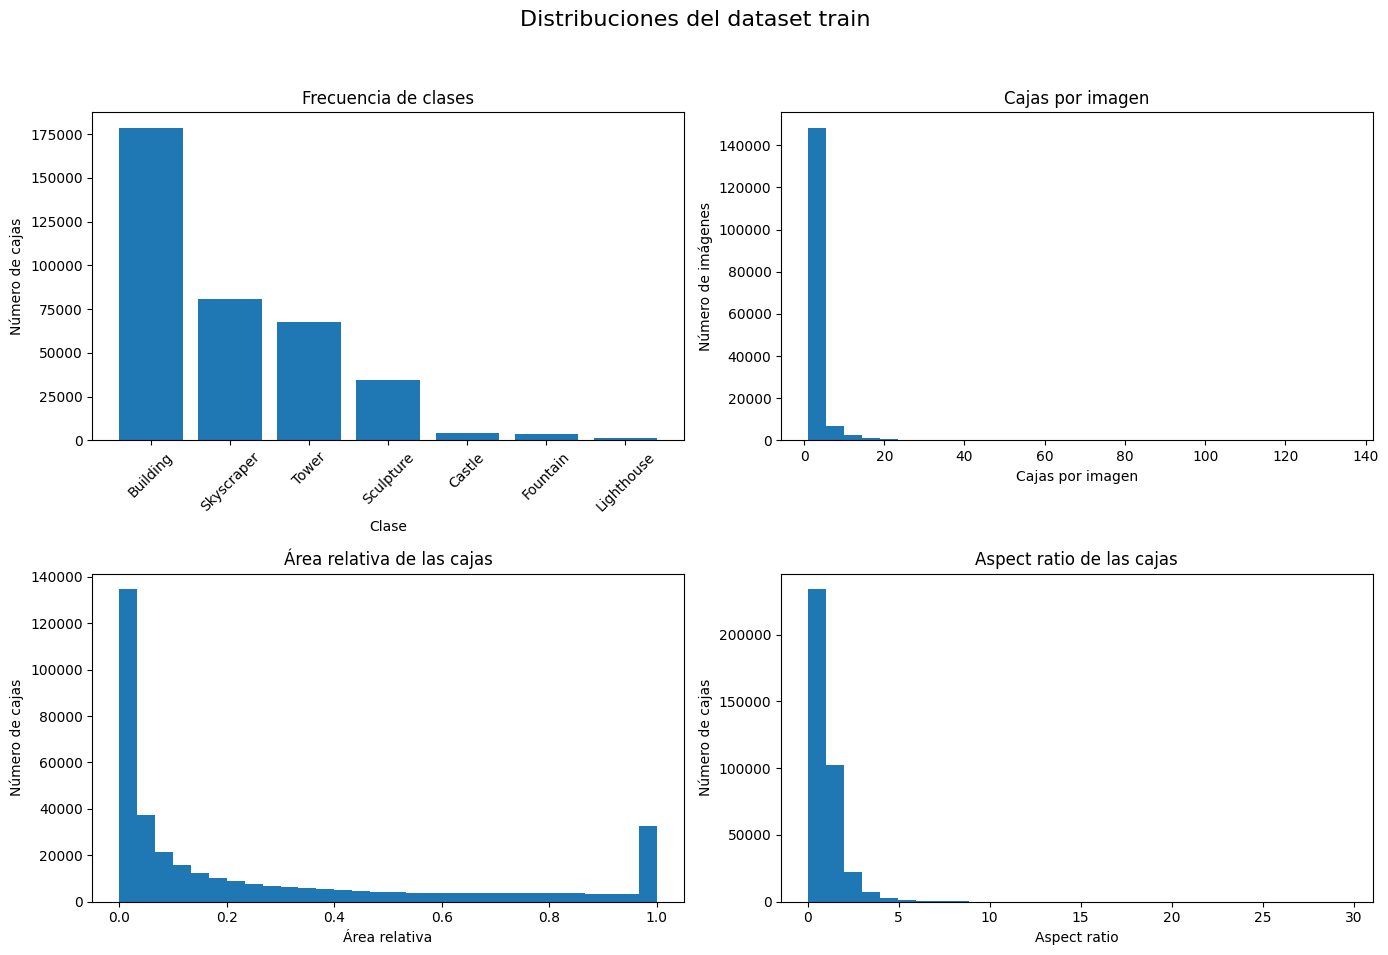

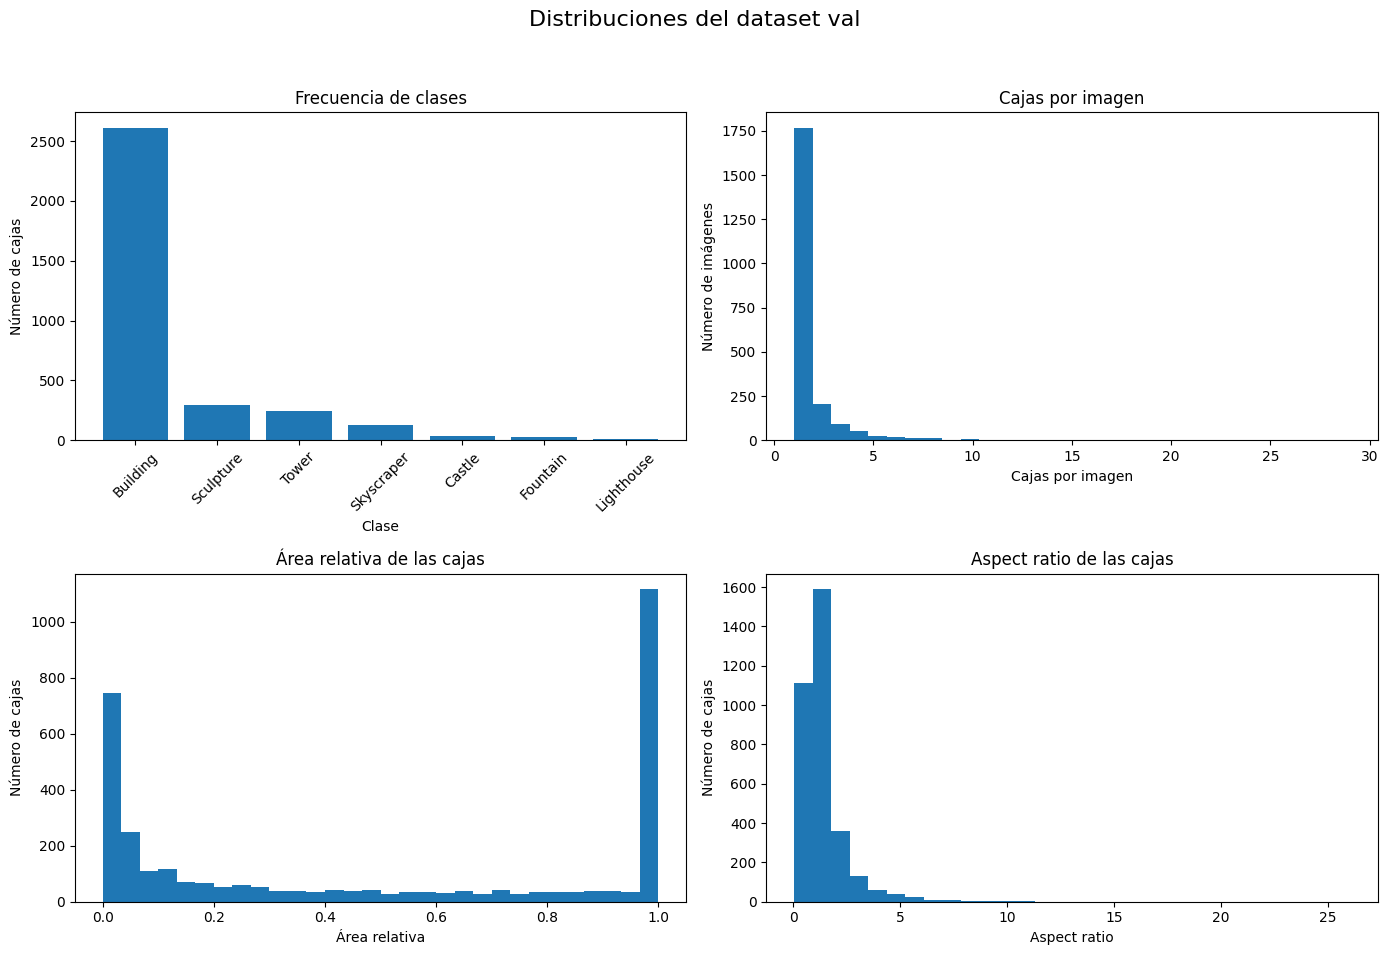

In [9]:
def plot_distribution_grid(df, name):
    """
    Muestra en una sola figura los cuatro gráficos de distribución
    para el DataFrame df:
      1) Frecuencia de clases
      2) Cajas por imagen
      3) Área relativa de las cajas
      4) Aspect ratio de las cajas
    """
    # Precomputos
    cls_counts    = df['label'].value_counts()
    boxes_per_img = df.groupby('image_id').size()
    areas_rel     = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
    widths_abs    = (df['xmax'] - df['xmin']) * df['width']
    heights_abs   = (df['ymax'] - df['ymin']) * df['height']
    aspect        = widths_abs / heights_abs

    # Creamos la figura con 2×2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1) Frecuencia de clases
    axs[0, 0].bar(cls_counts.index, cls_counts.values)
    axs[0, 0].set_title("Frecuencia de clases")
    axs[0, 0].set_xlabel("Clase")
    axs[0, 0].set_ylabel("Número de cajas")
    axs[0, 0].tick_params(axis='x', rotation=45)

    # 2) Cajas por imagen
    axs[0, 1].hist(boxes_per_img, bins=30)
    axs[0, 1].set_title("Cajas por imagen")
    axs[0, 1].set_xlabel("Cajas por imagen")
    axs[0, 1].set_ylabel("Número de imágenes")

    # 3) Área relativa de cada caja
    axs[1, 0].hist(areas_rel, bins=30)
    axs[1, 0].set_title("Área relativa de las cajas")
    axs[1, 0].set_xlabel("Área relativa")
    axs[1, 0].set_ylabel("Número de cajas")

    # 4) Aspect ratio (width/height)
    axs[1, 1].hist(aspect, bins=30)
    axs[1, 1].set_title("Aspect ratio de las cajas")
    axs[1, 1].set_xlabel("Aspect ratio")
    axs[1, 1].set_ylabel("Número de cajas")
    
    # Título general y ajuste de layout
    fig.suptitle(f"Distribuciones del dataset {name}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Para usar:
plot_distribution_grid(df_train_clean, "train")
plot_distribution_grid(df_val_clean,   "val")

In [10]:
def show_image_with_bboxes(image_id: str,
                           df: pd.DataFrame,
                           images_dir: str,
                           ext: str = ".jpg"):
    """
    Muestra la imagen con todos sus bounding boxes y etiquetas.

    Args:
        image_id (str): identificador de la imagen (sin extensión).
        df (pd.DataFrame): DataFrame de anotaciones con columnas
            ['image_id','label','xmin','ymin','xmax','ymax','width','height'].
        images_dir (str): carpeta donde están las imágenes.
        ext (str): extensión de los archivos (por defecto ".jpg").
    """
    # Construir ruta al archivo
    filename = image_id + ext
    img_path = os.path.join(images_dir, filename)
    img = Image.open(img_path).convert("RGB")
    
    # Filtrar anotaciones de esta imagen
    annots = df[df['image_id'] == image_id]
    if annots.empty:
        raise ValueError(f"No se encontraron anotaciones para image_id={image_id!r}")
    
    # Mostrar imagen
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    
    # Dibujar cada bbox
    for _, row in annots.iterrows():
        w_img = row['width']
        h_img = row['height']
        x1 = row['xmin'] * w_img
        y1 = row['ymin'] * h_img
        x2 = row['xmax'] * w_img
        y2 = row['ymax'] * h_img
        
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 5, row['label'],
            color='white',
            bbox=dict(facecolor='red', alpha=0.5, pad=0)
        )
    
    ax.axis('off')
    plt.title(f"Imagen: {filename}")
    plt.show()

In [11]:
# Ver la cantidad de bounding boxes por imagen

# Calcular cajas por imagen
boxes_per_img = df_train_clean.groupby('image_id').size()

# Estadísticas rápidas
print(boxes_per_img.describe())

# Listar las top-10 imágenes con más cajas
top10 = boxes_per_img.sort_values(ascending=False).head(10)
print("\nTop-10 imágenes con más cajas:")
print(top10)

count    159775.000000
mean          2.321990
std           3.492366
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         135.000000
dtype: float64

Top-10 imágenes con más cajas:
image_id
24b10e16fe35459b    135
47b9036d00bda22f    120
8870c32228c14beb    108
ce11f64612ad81ce    104
adb605ce1576eb66    100
2a73547ad1afacfa     97
f0d557ab79ec8dd0     89
cda11abf4f6cf045     89
cf476082d020fece     87
38dbf48f90bd364d     83
dtype: int64


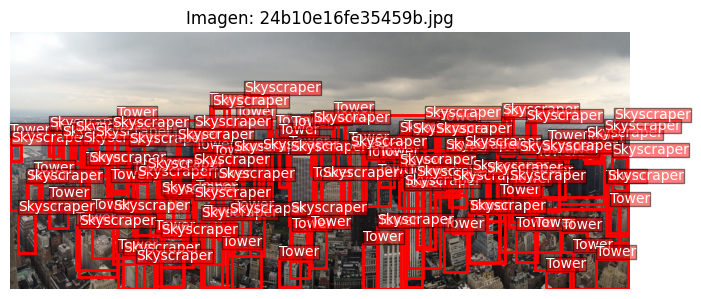

In [12]:
show_image_with_bboxes("24b10e16fe35459b", df_train, train_dataset_path)

Train — aspect_sym stats:
count    370989.000000
mean          2.150449
std           1.338566
min           1.000000
25%           1.334100
50%           1.727713
75%           2.499502
max          47.633413
dtype: float64
Train — percentiles 95/99%: {0.95: 4.529422747040892, 0.99: 7.425852018315017}


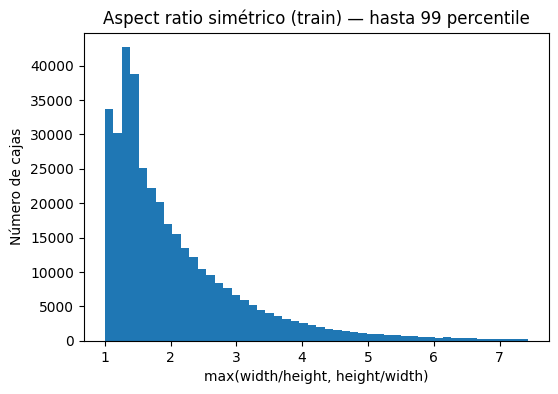

Train: 357389/370996 cajas tras filtrar aspect_sym > 5.0
 Val : 3205/3349 cajas tras filtrar aspect_sym > 5.0


In [13]:
# Umbral simétrico (max(width/height, height/width))
THRESH = 5.0

def compute_aspect_sym(df):
    # Cálculo absoluto
    widths_abs  = (df['xmax'] - df['xmin']) * df['width']
    heights_abs = (df['ymax'] - df['ymin']) * df['height']
    aspect_abs  = widths_abs / heights_abs

    # Proyección simétrica
    aspect_sym = aspect_abs.copy()
    aspect_sym[aspect_sym < 1.0] = 1.0 / aspect_sym[aspect_sym < 1.0]
    return aspect_sym

# Compute for train
aspect_sym_train = compute_aspect_sym(df_train_clean)
print("Train — aspect_sym stats:")
print(aspect_sym_train.describe())
print("Train — percentiles 95/99%:", aspect_sym_train.quantile([0.95,0.99]).to_dict())

# Histogram (train)
plt.figure(figsize=(6,4))
plt.hist(aspect_sym_train, bins=50, range=(1, aspect_sym_train.quantile(0.99)))
plt.title("Aspect ratio simétrico (train) — hasta 99 percentile")
plt.xlabel("max(width/height, height/width)")
plt.ylabel("Número de cajas")
plt.show()

# Filtrar cajas en train
mask_train_good = aspect_sym_train <= THRESH
df_train_filtered = df_train_clean[mask_train_good].reset_index(drop=True)
print(f"Train: {len(df_train_filtered)}/{len(df_train_clean)} cajas tras filtrar aspect_sym > {THRESH}")

# Compute & filtrar for val
aspect_sym_val = compute_aspect_sym(df_val_clean)
mask_val_good  = aspect_sym_val <= THRESH
df_val_filtered = df_val_clean[mask_val_good].reset_index(drop=True)
print(f" Val : {len(df_val_filtered)}/{len(df_val_clean)} cajas tras filtrar aspect_sym > {THRESH}")

In [14]:
class DatasetForDetection(Dataset):
    """
    Lee un DataFrame con columnas:
      image_id, label, xmin, ymin, xmax, ymax, height, width

    - xmin,ymin,xmax,ymax están normalizados [0,1].
    - label es string mapeado a entero via thing_classes.
    - height,width son enteros del tamaño original de la imagen.
    - transforms_v2 es un torchvision.transforms.v2.Compose que acepte
      (PIL.Image, BoundingBoxes) y devuelva (img_t, bbs_t).
    """
    def __init__(self,
                 images_dir: str,
                 annotations_df: pd.DataFrame,
                 thing_classes: list,
                 transforms_v2: T.Compose = None):
        self.images_dir    = images_dir
        self.annotations   = annotations_df.copy()
        self.image_ids     = self.annotations['image_id'].unique().tolist()
        self.class_to_idx  = {cls: i+1 for i, cls in enumerate(thing_classes)}
        self.transforms_v2 = transforms_v2

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        base_id  = self.image_ids[idx]
        # 1) Abrir imagen y obtener su tamaño original
        img_path = os.path.join(self.images_dir, base_id + ".jpg")
        img      = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size  # (width, height)

        # 2) Filtrar anotaciones de este ID
        annots = self.annotations[self.annotations['image_id'] == base_id]
        if annots.empty:
            raise ValueError(f"No hay anotaciones para image_id={base_id!r}")

        # 3) Convertir cajas relativas -> absolutas usando el tamaño real
        boxes_rel = annots[['xmin','ymin','xmax','ymax']].to_numpy(dtype='float32')
        boxes     = torch.from_numpy(boxes_rel)
        boxes[:, [0,2]] *= orig_w
        boxes[:, [1,3]] *= orig_h

        # 4) Etiquetas string -> índices
        labels = torch.tensor(
            [self.class_to_idx[l] for l in annots['label']],
            dtype=torch.int64
        )

        target = {"boxes": boxes, "labels": labels}

        # 5) Si hay transforms v2, aplicarlos y filtrar cajas degeneradas
        if self.transforms_v2 is not None:
            # Empaquetar BBoxes con canvas_size = (H, W)
            bbs = tv_tensors.BoundingBoxes(
                target["boxes"],
                format="XYXY",
                canvas_size=(orig_h, orig_w)
            )
            # Aplicar pipeline
            img_t, bbs_t = self.transforms_v2(img, bbs)

            # Extraer y filtrar las cajas con ancho/alto > 1e-3
            boxes_t = bbs_t.data
            labels_t = target["labels"]
            w = boxes_t[:,2] - boxes_t[:,0]
            h = boxes_t[:,3] - boxes_t[:,1]
            keep = (w > 1e-3) & (h > 1e-3)
            target["boxes"]  = boxes_t[keep]
            target["labels"] = labels_t[keep]

            # Convertir img_t a tensor C×H×W
            if isinstance(img_t, Image.Image):
                img = F.to_tensor(img_t)
            else:
                # de H×W×C a C×H×W si fuera necesario
                if img_t.ndim==3 and img_t.shape[-1] in (1,3):
                    img = img_t.permute(2,0,1)
                else:
                    img = img_t
        else:
            # Sin v2: solo ToTensor
            img = F.to_tensor(img)

        return img, target

In [15]:
# Definir pipeline v2
transforms_train = T.Compose([
    # Elige una región aleatoria y la reescala a 800×600 (4:3)
    T.RandomChoice([
        T.RandomResizedCrop(size=(800, 600), antialias=True),
        T.RandomResizedCrop(size=(800, 450), antialias=True),  # 16:9
    ]),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomPhotometricDistort(p=1.0),
    T.RandomAutocontrast(p=0.5),
    T.RandomEqualize(p=0.3),
    T.RandomPosterize(bits=4, p=0.2),
    T.RandomSolarize(threshold=128, p=0.2),
])

# Para validación no aplicamos augmentations
transforms_val = None

In [16]:
# Instanciar datasets
train_ds = DatasetForDetection(
    images_dir=train_dataset_path,
    annotations_df=df_train_filtered,
    thing_classes=thing_classes,
    transforms_v2=transforms_train
)
val_ds = DatasetForDetection(
    images_dir=val_dataset_path,
    annotations_df=df_val_filtered,
    thing_classes=thing_classes,
    transforms_v2=transforms_val
)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)
val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

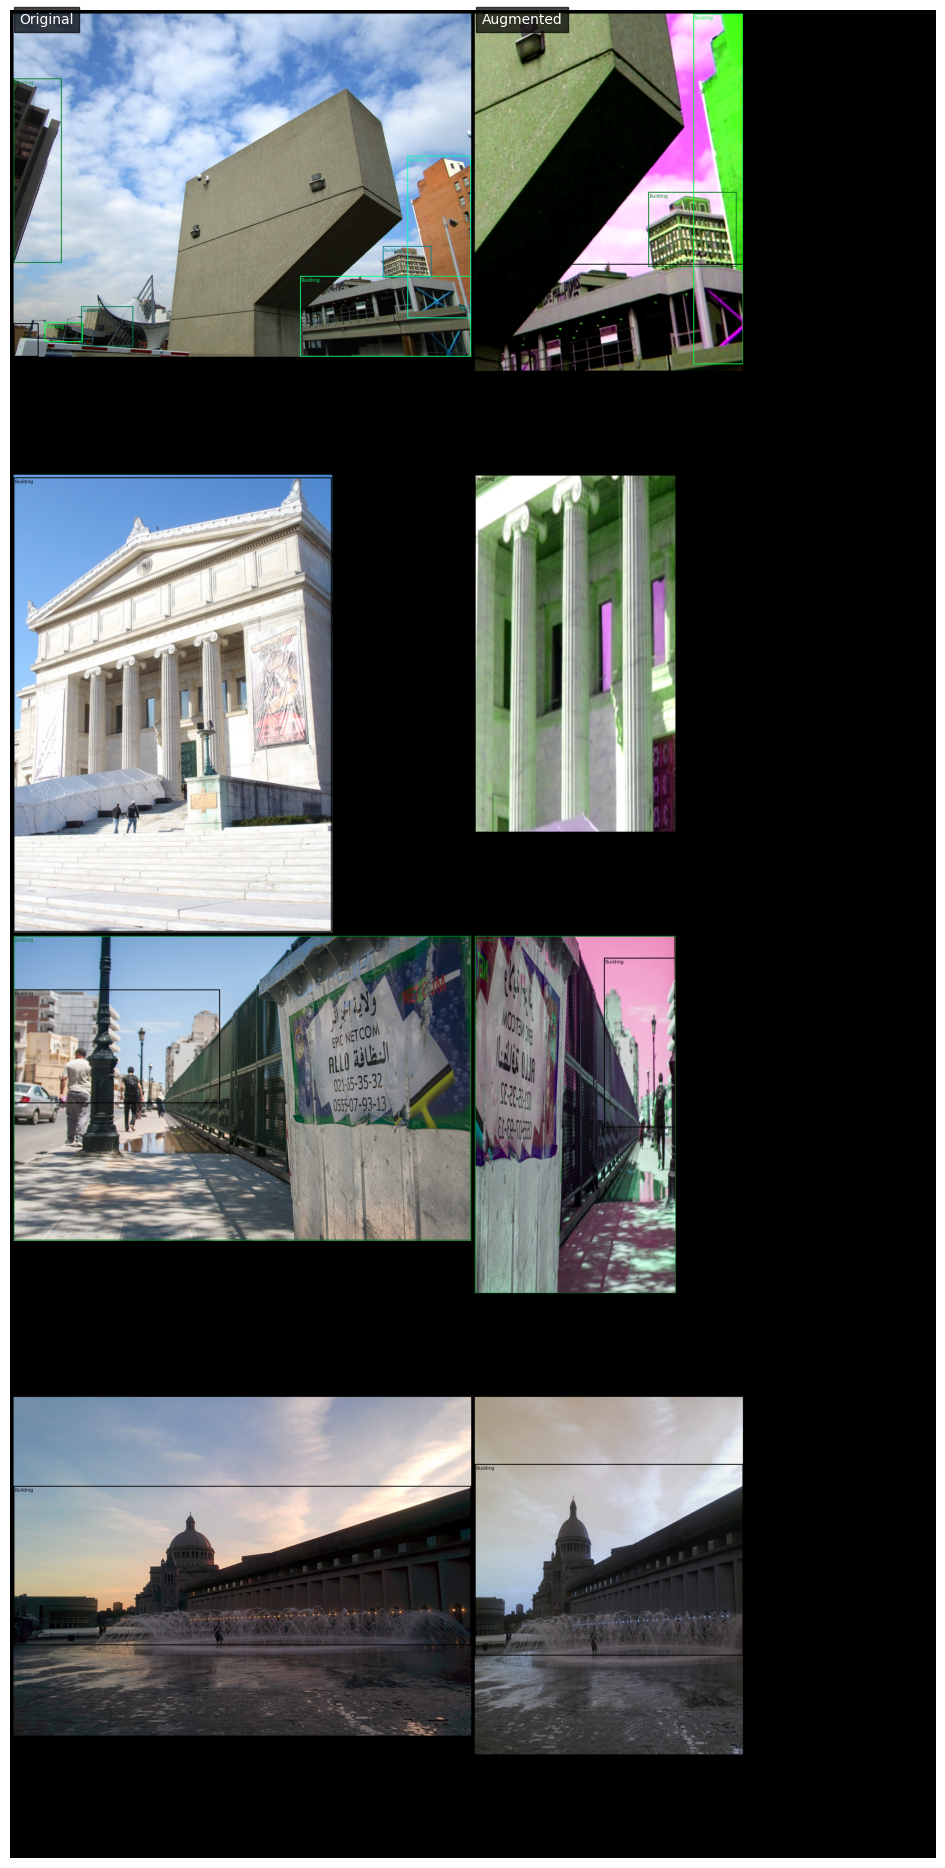

In [17]:
import torch.nn.functional as F_nn

def pad_to_max_size(tensors, pad_value=0):
    """
    Dada una lista de tensores [3,H_i,W_i], devuelve otra lista donde
    cada tensor se ha paddeado al (maxH, maxW) de todos ellos.
    """
    heights = [t.shape[1] for t in tensors]
    widths  = [t.shape[2] for t in tensors]
    maxH, maxW = max(heights), max(widths)
    
    padded = []
    for t in tensors:
        c, h, w = t.shape
        pad_bottom = maxH - h
        pad_right  = maxW - w
        # pad = (left, right, top, bottom)
        padded_t = F_nn.pad(t, (0, pad_right, 0, pad_bottom), mode="constant", value=pad_value)
        padded.append(padded_t)
    return padded

def compare_original_vs_augmented(orig_ds, aug_ds, indices):
    """
    Muestra una grilla comparando, para cada idx en `indices`,
    la imagen original vs. augmentada.
    """
    canvas = []
    for idx in indices:
        # Original
        img_o, tgt_o = orig_ds[idx]
        img_o_u8 = (img_o * 255).to(torch.uint8)
        labels_o  = [thing_classes[i-1] for i in tgt_o["labels"].tolist()]
        boxed_o = draw_bounding_boxes(
            img_o_u8,
            tgt_o["boxes"].to(torch.int64),
            labels=labels_o,
            width=2
        )
        canvas.append(boxed_o)
        
        # Augmented
        img_a, tgt_a = aug_ds[idx]
        img_a_u8 = (img_a * 255).to(torch.uint8)
        labels_a = [thing_classes[i-1] for i in tgt_a["labels"].tolist()]
        boxed_a = draw_bounding_boxes(
            img_a_u8,
            tgt_a["boxes"].to(torch.int64),
            labels=labels_a,
            width=2
        )
        canvas.append(boxed_a)
    
    # Pad todos al mismo tamaño
    canvas_padded = pad_to_max_size(canvas, pad_value=0)

    # Montar grilla 2 columnas
    grid = make_grid(canvas_padded, nrow=2, padding=8)

    # Mostrar
    plt.figure(figsize=(12, 6 * len(indices)))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    # Títulos
    H, W = grid.shape[1], grid.shape[2]
    plt.text(20, 30,       "Original",   color='white',
             bbox=dict(facecolor='black', alpha=0.7, pad=4))
    plt.text(W//2+20, 30,  "Augmented",  color='white',
             bbox=dict(facecolor='black', alpha=0.7, pad=4))
    plt.show()

# Uso:
orig_ds = DatasetForDetection(
    images_dir=train_dataset_path,
    annotations_df=df_train_filtered,
    thing_classes=thing_classes,
    transforms_v2=None
)

compare_original_vs_augmented(orig_ds, train_ds, indices=[0, 15, 42, 123])

In [18]:
# Cargar CVNet
cvnet_path = os.path.join(base_path, "image_retrieval", "backbones")
assert os.path.isdir(cvnet_path), f"No existe {cvnet_path}"

if cvnet_path not in sys.path:
    sys.path.insert(0, cvnet_path)

from cvnet.cvnet_model import CVNet_Rerank

In [19]:
# Instanciar CVNet
RESNET_DEPTH = 50
REDUCTION_DIM = 2048
cvnet = CVNet_Rerank(RESNET_DEPTH=RESNET_DEPTH, REDUCTION_DIM=REDUCTION_DIM)

# Cargar los pesos pre-entrenados
pretrained_weights_path = os.path.join(base_path, "assets", "weights", "CVPR2022_CVNet_R50.pyth")
checkpoint = torch.load(pretrained_weights_path, map_location=device)
state_dict = checkpoint.get('model_state', checkpoint)
cvnet.encoder_q.load_state_dict(state_dict, strict=False)

# Congelar el backbone
for param in cvnet.encoder_q.parameters():
    param.requires_grad = False

In [20]:
class CVNetFPN(nn.Module):
    """
    Wrapper de CVNet_Rerank, extrae las stages y
    les aplica un FPN manualmente.
    """
    def __init__(self, cvnet, in_channels_list, out_channels):
        super().__init__()
        self.cvnet = cvnet
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=LastLevelMaxPool()
        )
        # FasterRCNN necesita que el backbone tenga este atributo
        self.out_channels = out_channels

    def forward(self, x):
        # extract_backbone_stages devuelve OrderedDict(
        #    res2->Tensor, res3->Tensor, res4->Tensor, res5->Tensor
        # )
        feats = self.cvnet.extract_backbone_stages(x)
        # Aplicar FPN y devolver otro OrderedDict con los maps finales
        return self.fpn(feats)

In [21]:
# Añadir FPN sobre esos cuatro niveles
backbone_with_fpn = CVNetFPN(
    cvnet=cvnet,
    in_channels_list=[256, 512, 1024, 2048],
    out_channels=256
)

In [22]:
# Uno por cada feature map: 4 de FPN + 1 del backbone directo
sizes = [
    (16, 32, 64),     # nivel 0 (res2 / FPN 0)
    (32, 64, 128),    # nivel 1 (res3 / FPN 1)
    (64, 128, 256),   # nivel 2 (res4 / FPN 2)
    (128, 256, 512),  # nivel 3 (res5 / FPN 3)
    (256, 512, 1024)  # nivel 4 (salida directa del backbone)
]

# Agregar aspect ratios hasta 5 para cubrir la mayoría de los objetos del dataset
aspect_ratios = [
    (0.2, 0.5, 1.0, 2.0, 5.0),  # para nivel 0
    (0.2, 0.5, 1.0, 2.0, 5.0),  # para nivel 1
    (0.2, 0.5, 1.0, 2.0, 5.0),  # para nivel 2
    (0.2, 0.5, 1.0, 2.0, 5.0),  # para nivel 3
    (0.2, 0.5, 1.0, 2.0, 5.0),  # para nivel 4
]

anchor_generator = AnchorGenerator(
    sizes=tuple(sizes),
    aspect_ratios=tuple(aspect_ratios)
)

In [23]:
box_roi_pool = MultiScaleRoIAlign(
    featmap_names=['res2', 'res3', 'res4', 'res5'],  # coinciden con las claves de CVNetFPN
    output_size=7,
    sampling_ratio=2
)

In [24]:
# Crear el Faster R-CNN usando tu backbone+FPN
model = FasterRCNN(
    backbone=backbone_with_fpn,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=box_roi_pool
)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): CVNetFPN(
    (cvnet): CVNet_Rerank(
      (encoder_q): ResNet(
        (stem): ResStemIN(
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (s1): ResStage(
          (b1): ResBlock(
            (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (f): BottleneckTransform(
              (a): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (a_bn): B

In [25]:
# Carpeta donde deseas guardar los checkpoints
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, scheduler, path):
    """
    Guarda el estado completo del entrenamiento en `path`.
    """
    torch.save({
        "epoch": epoch,
        "model_state":      model.state_dict(),
        "optimizer_state":  optimizer.state_dict(),
        "scheduler_state":  scheduler.state_dict(),
        "loss_schedule":    LOSS_SCHEDULE,
    }, path)

In [26]:
import math
from torch.optim.lr_scheduler import LinearLR, StepLR

# ---------------- Hyperparámetros ----------------
LR            = 0.0005
MOMENTUM      = 0.9
WEIGHT_DECAY  = 0.0005
STEP_SIZE     = 1
GAMMA         = 0.1
NUM_EPOCHS    = 10
BATCH_SIZE    = 2
WARMUP_ITERS = 1000

VAL_INTERVAL   = 1000
NUM_EXAMPLES = 4    # cuántas imágenes enviar

LOSS_NAMES = [
    "loss_objectness",
    "loss_rpn_box_reg",
    "loss_classifier",
    "loss_box_reg",
]

# Pesos para escalar cada loss
LOSS_SCHEDULE = [
    {"loss_objectness":1.0, "loss_rpn_box_reg":1.0, "loss_classifier":0.2, "loss_box_reg":0.2},
    {"loss_objectness":0.8, "loss_rpn_box_reg":0.8, "loss_classifier":0.5, "loss_box_reg":0.5},
    {"loss_objectness":0.5, "loss_rpn_box_reg":0.5, "loss_classifier":0.8, "loss_box_reg":0.8},
    {"loss_objectness":1.0, "loss_rpn_box_reg":1.0, "loss_classifier":1.0, "loss_box_reg":1.0},
    {"loss_objectness":1.0, "loss_rpn_box_reg":1.0, "loss_classifier":1.0, "loss_box_reg":1.0},
]

# 1) Parámetros a optimizar
params = [p for p in model.parameters() if p.requires_grad]

# Optimizador
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Scheduler
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.1,      # arranca al 10% de la lr
    end_factor=1.0,        # termina en el 100%
    total_iters=WARMUP_ITERS
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=STEP_SIZE,
    gamma=GAMMA
)

# W&B init
wandb.init(
    project="fasterrcnn-cvnet",
)
wandb.config.update({
    "lr": LR,
    "momentum": MOMENTUM,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "num_epochs": NUM_EPOCHS,
    "loss_weights": LOSS_SCHEDULE
})

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: theviderlab (theviderlab-viderlab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Tried to log to step 5000 that is less than the current step 5001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6000 that is less than the current step 6001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7000 that is less than the current step 7001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8000 that is less than the current step 8001. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


In [ ]:
# Training loop
global_step = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    weights = LOSS_SCHEDULE[epoch]

    print(f"\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===")

    for batch_idx, (images, targets) in enumerate(train_loader, start=1):
        global_step += 1

        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward y cálculo de loss
        loss_dict = model(images, targets)
        weighted_losses = [weights[name] * loss_dict[name] for name in loss_dict]
        total_loss = sum(weighted_losses)

        # Saltar batch si la loss total no es finita
        if not torch.isfinite(total_loss):
            print(f"⚠️  Saltando batch {batch_idx} por total_loss={total_loss}")
            continue

        # Backward y clipping de gradientes
        total_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        # Logging y prints
        batch_loss = total_loss.item()
        epoch_loss += batch_loss
        current_lr = optimizer.param_groups[0]['lr']
        log_data = {f"train/{k}": v.item() for k, v in loss_dict.items()}
        log_data["train/total_loss"]     = batch_loss
        log_data["train/learning_rate"]  = current_lr
        wandb.log(log_data)
        if batch_idx % 10 == 0 or batch_idx == len(train_loader):
            losses_str = ", ".join(
                f"{name}: {loss_dict[name].item():.4f}"
                for name in LOSS_NAMES
            )
            print(
                f"Batch {batch_idx}/{len(train_loader)} — "
                f"{losses_str} — total_loss: {batch_loss:.4f} — lr: {current_lr:.6f}"
            )

        if global_step <= WARMUP_ITERS:
            warmup_scheduler.step()

        if global_step % VAL_INTERVAL == 0:
            # 1) LOSS SOBRE VALIDACIÓN
            sum_losses = {k: 0.0 for k in LOSS_SCHEDULE[0].keys()}
            sum_losses["total_loss"] = 0.0
            n_batches = 0

            # 2) EJEMPLOS PARA W&B
            examples = []

            with torch.no_grad():
                for i, (v_images, v_targets) in enumerate(val_loader):
                    # mover a device
                    v_images  = [img.to(device) for img in v_images]
                    v_targets = [{k: v.to(device) for k,v in t.items()} for t in v_targets]

                    # —> Forzamos modo train solo para calcular la loss
                    model.train()
                    loss_dict = model(v_images, v_targets)
                    batch_losses = {k: loss_dict[k].item() for k in loss_dict}
                    total_vloss = sum(batch_losses.values())
                    for k,v in batch_losses.items():
                        sum_losses[k] += v
                    sum_losses["total_loss"] += total_vloss
                    n_batches += 1

                    # —> Ahora sí, en modo eval para obtener predicciones
                    model.eval()
                    preds = model(v_images)
                    pred = preds[0]

                    # Acumulamos un par de estadísticas de predicción
                    sum_losses.setdefault("n_preds", 0.0)
                    sum_losses.setdefault("avg_score", 0.0)
                    sum_losses["n_preds"]   += len(pred["boxes"])
                    sum_losses["avg_score"] += (pred["scores"].mean().item()
                                                if len(pred["scores"])>0 else 0.0)

                    # Guardar algunos ejemplos visuales
                    if i < NUM_EXAMPLES:
                        img_u8     = (v_images[0]*255).to(torch.uint8)
                        gt_boxes   = v_targets[0]["boxes"].cpu()
                        gt_labels  = [thing_classes[l-1]
                                      for l in v_targets[0]["labels"].cpu()]
                        pred_boxes = pred["boxes"].cpu()
                        pred_labels= [thing_classes[l-1]
                                      for l in pred["labels"].cpu()]

                        img_vis = draw_bounding_boxes(
                            img_u8,
                            boxes=torch.cat([gt_boxes, pred_boxes], dim=0),
                            labels=gt_labels + pred_labels,
                            colors=(["green"]*len(gt_boxes) + ["red"]*len(pred_boxes)),
                            width=2
                        )
                        examples.append(
                            wandb.Image(
                                img_vis.permute(1,2,0).numpy(),
                                caption=f"step {global_step}"
                            )
                        )

            if n_batches == 0:
                print(f"⚠️  Skip validation at step {global_step}: no valid batches")
                model.train()
                continue

            # 3) Cálculo de medias
            avg = {}
            for k,v in sum_losses.items():
                avg[k] = v / n_batches
            # Preparo el dict para W&B
            log_data = {
                **{f"val/{k}": avg[k] for k in LOSS_SCHEDULE[0].keys()},
                "val/total_loss": avg["total_loss"],
                "val/n_preds":    avg["n_preds"],
                "val/avg_score":  avg["avg_score"],
                "val/step":       global_step,
                "val/examples":   examples
            }

            # 4) Loggear todo junto
            wandb.log(log_data, step=global_step)

            print(
                f"🔍 Validation @step {global_step} — " +
                ", ".join(
                    f"{name}={log_data[f'val/{name}']:.4f}"
                    for name in LOSS_NAMES
                ) +
                f", n_preds={log_data['val/n_preds']:.1f}" +
                f", avg_score={log_data['val/avg_score']:.3f}"
            )

            # Volvemos a train para continuar el bucle de entrenamiento
            model.train()
 
    # Scheduler step
    lr_scheduler.step()

    # Guardar checkpoint
    ckpt_path = os.path.join(
        CHECKPOINT_DIR,
        f"checkpoint_epoch{epoch+1:02d}.pth"
    )
    save_checkpoint(
        epoch+1,
        model,
        optimizer,
        lr_scheduler,
        ckpt_path
    )
    print(f"✅ Guardado checkpoint: {ckpt_path}")
    
    # Logging epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "epoch":            epoch + 1
    })
    print(f"Epoch {epoch+1} average loss: {avg_epoch_loss:.4f}")

    # Vaciar la cache de la GPU
    torch.cuda.empty_cache()


=== Epoch 1/10 ===
Batch 10/4943 — loss_objectness: 0.7027, loss_rpn_box_reg: 0.1114, loss_classifier: 1.5028, loss_box_reg: 0.0037 — total_loss: 1.1154 — lr: 0.000054
Batch 20/4943 — loss_objectness: 0.6985, loss_rpn_box_reg: 0.1065, loss_classifier: 0.8287, loss_box_reg: 0.0020 — total_loss: 0.9711 — lr: 0.000059
Batch 30/4943 — loss_objectness: 0.6847, loss_rpn_box_reg: 0.0395, loss_classifier: 0.6046, loss_box_reg: 0.0034 — total_loss: 0.8458 — lr: 0.000063
Batch 40/4943 — loss_objectness: 0.6730, loss_rpn_box_reg: 0.1258, loss_classifier: 0.4755, loss_box_reg: 0.0024 — total_loss: 0.8944 — lr: 0.000068
Batch 50/4943 — loss_objectness: 0.6592, loss_rpn_box_reg: 0.0676, loss_classifier: 0.4584, loss_box_reg: 0.0005 — total_loss: 0.8186 — lr: 0.000072
Batch 60/4943 — loss_objectness: 0.6455, loss_rpn_box_reg: 0.1199, loss_classifier: 0.4268, loss_box_reg: 0.0038 — total_loss: 0.8516 — lr: 0.000077
Batch 70/4943 — loss_objectness: 0.6347, loss_rpn_box_reg: 0.1110, loss_classifier: 0.

🔍 Validation @step 1000 — loss_objectness=0.1477, loss_rpn_box_reg=0.0404, loss_classifier=0.1218, loss_box_reg=0.1176, n_preds=12.0, avg_score=0.156
Batch 1010/4943 — loss_objectness: 0.1448, loss_rpn_box_reg: 0.0912, loss_classifier: 0.1798, loss_box_reg: 0.1812 — total_loss: 0.3081 — lr: 0.000500
Batch 1020/4943 — loss_objectness: 0.1028, loss_rpn_box_reg: 0.0458, loss_classifier: 0.1292, loss_box_reg: 0.1225 — total_loss: 0.1989 — lr: 0.000500
Batch 1030/4943 — loss_objectness: 0.0818, loss_rpn_box_reg: 0.0267, loss_classifier: 0.1184, loss_box_reg: 0.1175 — total_loss: 0.1557 — lr: 0.000500
Batch 1040/4943 — loss_objectness: 0.1810, loss_rpn_box_reg: 0.1304, loss_classifier: 0.1618, loss_box_reg: 0.1345 — total_loss: 0.3707 — lr: 0.000500
Batch 1050/4943 — loss_objectness: 0.1051, loss_rpn_box_reg: 0.0424, loss_classifier: 0.1543, loss_box_reg: 0.1424 — total_loss: 0.2068 — lr: 0.000500
Batch 1060/4943 — loss_objectness: 0.1218, loss_rpn_box_reg: 0.0443, loss_classifier: 0.1704, l

🔍 Validation @step 2000 — loss_objectness=0.1278, loss_rpn_box_reg=0.0358, loss_classifier=0.1185, loss_box_reg=0.1169, n_preds=10.5, avg_score=0.168
Batch 2010/4943 — loss_objectness: 0.1856, loss_rpn_box_reg: 0.0659, loss_classifier: 0.1693, loss_box_reg: 0.1490 — total_loss: 0.3151 — lr: 0.000500
Batch 2020/4943 — loss_objectness: 0.1399, loss_rpn_box_reg: 0.0549, loss_classifier: 0.1665, loss_box_reg: 0.1430 — total_loss: 0.2567 — lr: 0.000500
Batch 2030/4943 — loss_objectness: 0.1226, loss_rpn_box_reg: 0.0511, loss_classifier: 0.1783, loss_box_reg: 0.1546 — total_loss: 0.2404 — lr: 0.000500
Batch 2040/4943 — loss_objectness: 0.0762, loss_rpn_box_reg: 0.0628, loss_classifier: 0.1322, loss_box_reg: 0.1346 — total_loss: 0.1924 — lr: 0.000500
Batch 2050/4943 — loss_objectness: 0.2116, loss_rpn_box_reg: 0.1040, loss_classifier: 0.1743, loss_box_reg: 0.1727 — total_loss: 0.3850 — lr: 0.000500
Batch 2060/4943 — loss_objectness: 0.1055, loss_rpn_box_reg: 0.0639, loss_classifier: 0.1743, l

🔍 Validation @step 3000 — loss_objectness=0.1300, loss_rpn_box_reg=0.0343, loss_classifier=0.1129, loss_box_reg=0.1141, n_preds=11.1, avg_score=0.166
Batch 3010/4943 — loss_objectness: 0.1395, loss_rpn_box_reg: 0.0669, loss_classifier: 0.1498, loss_box_reg: 0.1378 — total_loss: 0.2639 — lr: 0.000500
Batch 3020/4943 — loss_objectness: 0.1347, loss_rpn_box_reg: 0.0474, loss_classifier: 0.1855, loss_box_reg: 0.1686 — total_loss: 0.2529 — lr: 0.000500
Batch 3030/4943 — loss_objectness: 0.1073, loss_rpn_box_reg: 0.0486, loss_classifier: 0.1536, loss_box_reg: 0.1436 — total_loss: 0.2154 — lr: 0.000500
Batch 3040/4943 — loss_objectness: 0.0826, loss_rpn_box_reg: 0.0383, loss_classifier: 0.1400, loss_box_reg: 0.1413 — total_loss: 0.1772 — lr: 0.000500
Batch 3050/4943 — loss_objectness: 0.1227, loss_rpn_box_reg: 0.0527, loss_classifier: 0.1728, loss_box_reg: 0.1464 — total_loss: 0.2393 — lr: 0.000500
Batch 3060/4943 — loss_objectness: 0.1089, loss_rpn_box_reg: 0.0544, loss_classifier: 0.1654, l

🔍 Validation @step 5000 — loss_objectness=0.1252, loss_rpn_box_reg=0.0321, loss_classifier=0.1127, loss_box_reg=0.1143, n_preds=11.4, avg_score=0.146
Batch 60/4943 — loss_objectness: 0.1050, loss_rpn_box_reg: 0.0393, loss_classifier: 0.1360, loss_box_reg: 0.1261 — total_loss: 0.2465 — lr: 0.000050
Batch 70/4943 — loss_objectness: 0.1121, loss_rpn_box_reg: 0.0351, loss_classifier: 0.1494, loss_box_reg: 0.1347 — total_loss: 0.2598 — lr: 0.000050
Batch 80/4943 — loss_objectness: 0.1340, loss_rpn_box_reg: 0.0509, loss_classifier: 0.1383, loss_box_reg: 0.1357 — total_loss: 0.2850 — lr: 0.000050
Batch 90/4943 — loss_objectness: 0.2038, loss_rpn_box_reg: 0.0666, loss_classifier: 0.2002, loss_box_reg: 0.1595 — total_loss: 0.3962 — lr: 0.000050
Batch 100/4943 — loss_objectness: 0.1148, loss_rpn_box_reg: 0.0571, loss_classifier: 0.1761, loss_box_reg: 0.1639 — total_loss: 0.3075 — lr: 0.000050
Batch 110/4943 — loss_objectness: 0.0954, loss_rpn_box_reg: 0.0354, loss_classifier: 0.1306, loss_box_re

🔍 Validation @step 6000 — loss_objectness=0.1279, loss_rpn_box_reg=0.0326, loss_classifier=0.1104, loss_box_reg=0.1118, n_preds=10.8, avg_score=0.147
Batch 1060/4943 — loss_objectness: 0.1809, loss_rpn_box_reg: 0.0735, loss_classifier: 0.1512, loss_box_reg: 0.1307 — total_loss: 0.3444 — lr: 0.000050
Batch 1070/4943 — loss_objectness: 0.0716, loss_rpn_box_reg: 0.0234, loss_classifier: 0.1372, loss_box_reg: 0.1263 — total_loss: 0.2078 — lr: 0.000050
Batch 1080/4943 — loss_objectness: 0.0859, loss_rpn_box_reg: 0.0433, loss_classifier: 0.1387, loss_box_reg: 0.1408 — total_loss: 0.2431 — lr: 0.000050
Batch 1090/4943 — loss_objectness: 0.1399, loss_rpn_box_reg: 0.0843, loss_classifier: 0.1673, loss_box_reg: 0.1498 — total_loss: 0.3380 — lr: 0.000050
Batch 1100/4943 — loss_objectness: 0.0900, loss_rpn_box_reg: 0.0662, loss_classifier: 0.1503, loss_box_reg: 0.1392 — total_loss: 0.2697 — lr: 0.000050
Batch 1110/4943 — loss_objectness: 0.1662, loss_rpn_box_reg: 0.0692, loss_classifier: 0.1465, l

🔍 Validation @step 7000 — loss_objectness=0.1279, loss_rpn_box_reg=0.0326, loss_classifier=0.1103, loss_box_reg=0.1121, n_preds=11.0, avg_score=0.148
Batch 2060/4943 — loss_objectness: 0.1966, loss_rpn_box_reg: 0.0753, loss_classifier: 0.1745, loss_box_reg: 0.1428 — total_loss: 0.3761 — lr: 0.000050
Batch 2070/4943 — loss_objectness: 0.1400, loss_rpn_box_reg: 0.0529, loss_classifier: 0.1279, loss_box_reg: 0.1124 — total_loss: 0.2745 — lr: 0.000050
Batch 2080/4943 — loss_objectness: 0.1239, loss_rpn_box_reg: 0.0797, loss_classifier: 0.1966, loss_box_reg: 0.1843 — total_loss: 0.3533 — lr: 0.000050
Batch 2090/4943 — loss_objectness: 0.1457, loss_rpn_box_reg: 0.0743, loss_classifier: 0.1693, loss_box_reg: 0.1543 — total_loss: 0.3378 — lr: 0.000050
Batch 2100/4943 — loss_objectness: 0.0923, loss_rpn_box_reg: 0.0343, loss_classifier: 0.1641, loss_box_reg: 0.1511 — total_loss: 0.2589 — lr: 0.000050
Batch 2110/4943 — loss_objectness: 0.1207, loss_rpn_box_reg: 0.0536, loss_classifier: 0.1858, l

🔍 Validation @step 8000 — loss_objectness=0.1274, loss_rpn_box_reg=0.0325, loss_classifier=0.1111, loss_box_reg=0.1121, n_preds=10.9, avg_score=0.145
Batch 3060/4943 — loss_objectness: 0.1569, loss_rpn_box_reg: 0.0479, loss_classifier: 0.1378, loss_box_reg: 0.1179 — total_loss: 0.2917 — lr: 0.000050
